In [ ]:
!pip install torch pandas numpy transformers matplotlib ipywidgets catboost scikit-learn shap seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 41.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 87.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 119.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 40.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 76.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.4/996.4 kB 71.8 MB/s eta 0:

In [ ]:
import gc
import torch

# PyTorch GPU 캐시 비우기
torch.cuda.empty_cache()

# Python 객체 참조 해제 및 가비지 컬렉션
gc.collect()

[E01][B000] loss=62.0435 | RMSE=142.0897 | MAE=140.1005 | MAPE=93.99% | SMAPE=177.40% | 예측값: [ 6.6184435 16.55122   15.162151 ] | 실제값: [148. 139. 129.]
[E01][B010] loss=64.9644 | RMSE=23.1045 | MAE=21.7826 | MAPE=78.26% | SMAPE=54.72% | 예측값: [42.288765 42.97175  54.912933] | 실제값: [29. 27. 29.]
[E01][B020] loss=90.4021 | RMSE=30.4988 | MAE=29.6585 | MAPE=99.26% | SMAPE=64.55% | 예측값: [54.651253 55.054398 49.087914] | 실제값: [28. 30. 33.]
[E01][B030] loss=44.1660 | RMSE=40.8124 | MAE=28.6478 | MAPE=30.43% | SMAPE=41.38% | 예측값: [63.43392  67.72739  56.234108] | 실제값: [67. 63. 59.]
[E01][B040] loss=23.9097 | RMSE=32.5054 | MAE=30.7172 | MAPE=174.25% | SMAPE=84.31% | 예측값: [54.846977 53.975754 54.894493] | 실제값: [23. 22. 24.]
[E01][B050] loss=41.2641 | RMSE=38.3050 | MAE=32.7503 | MAPE=69.49% | SMAPE=51.22% | 예측값: [82.72956  84.522385 94.51873 ] | 실제값: [95. 87. 71.]
[E01][B060] loss=84.2642 | RMSE=94.8008 | MAE=83.8618 | MAPE=40.77% | SMAPE=56.62% | 예측값: [120.0727   124.457504 126.81231 ] | 실제값: 

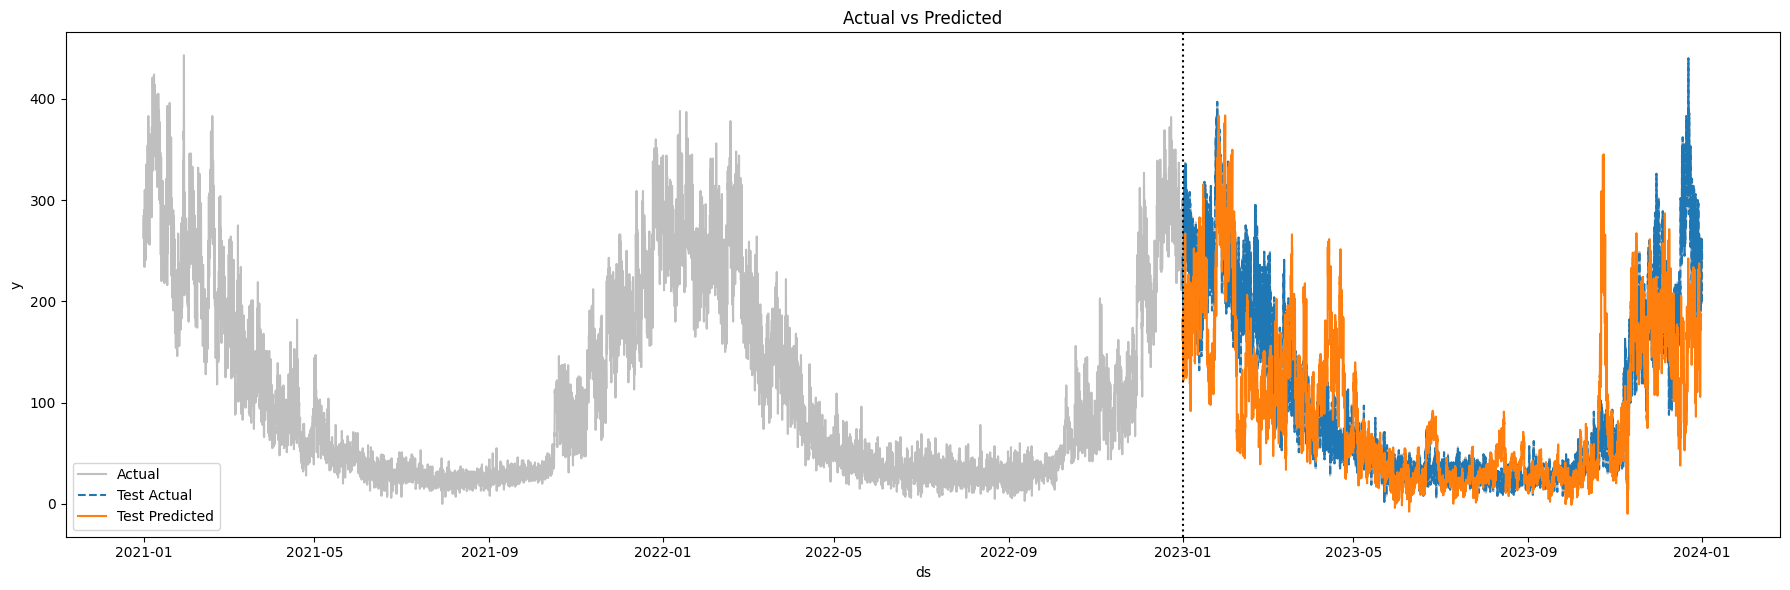

In [ ]:
import gc
import torch
import math
import time
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoConfig, AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
import shap

# -----------------------------
# (1) Dataset
# 목적: 시계열 데이터를 PyTorch 학습용으로 변환
# 시계열 데이터에서 입력 구간과 예측 구간을 잘라서 모델에 전달하는 역할
# -----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, target_col="y"):
        self.seq_len   = seq_len     # 입력 시퀀스 길이 (168시간 = 7일)
        self.pred_len  = pred_len    # 예측 시퀀스 길이 (24시간 = 1일)
        self.target_col= target_col  # 예측 대상 컬럼
        self.df        = df.reset_index(drop=True)
        self.features  = [c for c in df.columns if c not in ["ds", target_col]] # 날짜(ds), 타겟 컬럼 제외 -> 입력될 피쳐목록
        self.data      = df[self.features].values.astype(np.float32) # 딥러닝 연산 위한 float32 타입 변환
        self.targets   = df[target_col].values.astype(np.float32)

    def __len__(self): # 데이터셋의 전체 길이 반환
        return len(self.df) - self.seq_len - self.pred_len + 1 # seq_len(7일) + pred_len(1일) 만큼의 길이만큼만 반환

    def __getitem__(self, idx): # 인덱스에 해당하는 데이터 반환
        x_enc   = self.data[idx : idx + self.seq_len] # 과거 seq_len(7일) 동안의 입력 데이터
        y_label = self.targets[idx + self.seq_len : idx + self.seq_len + self.pred_len] # 미래 타겟 데이터 : seq_len(7일) 이후부터 pred_len(1일) 동안의 타겟 데이터
        return (
            torch.tensor(x_enc),                # [seq_len, n_features] # 입력 시퀀스
            torch.tensor([]),                   # dummy # 더미 데이터 (사용하지 않음), 구조맞추기용
            torch.tensor(y_label).unsqueeze(-1) # [pred_len, 1] 예측할 타겟 시퀀스 (1일치)
        )

# -----------------------------
# (2) RevIN : 시계열 데이터의 비정상성 문제를 해결위함 
# 목적: 입력 시퀀스의 정규화 및 역정규화
# 각 배치별로 정규화된 입력을 제공하고, 모델이 예측한 값을 원래 스케일로 되돌리는 역할
# -----------------------------
class RevIN(nn.Module):
    def __init__(self, num_features, affine=True, eps=1e-5):
        super().__init__()
        self.affine = affine
        self.eps    = eps # 작은 값, 0으로 나누는 것을 방지하기 위함
        if affine: # gamma, beta: 학습 가능한 파라미터
            self.gamma = nn.Parameter(torch.ones(1,1,num_features))
            self.beta  = nn.Parameter(torch.zeros(1,1,num_features))

    def forward(self, x, mode):
        if mode == "norm":  # 입력 x를 feature별로 평균(m), 표준편차(s)로 정규화
            m = x.mean(dim=1, keepdim=True)
            s = x.std(dim=1, keepdim=True)
            xn = (x - m) / (s + self.eps) # eps를 더해 0으로 나누는 것을 방지
            if self.affine: # 정규화된 x에 대해 gamma, beta를 곱하고 더함 -> 모델이 데이터 분포를 더 잘맞추도록 감마, 베타 학습 
                xn = xn * self.gamma + self.beta
            return xn, m, s
        elif mode == "denorm": # 정규화된 x를 원래 스케일로 되돌림
            xn, m, s = x
            if self.affine:
                xn = (xn - self.beta) / (self.gamma + self.eps) # 아핀 역변환
            return xn * (s + self.eps) + m # 원래 스케일로 복원
        else:
            raise ValueError("mode must be 'norm' or 'denorm'")

# -----------------------------
# (3) PatchEmbedding
# 목적: 입력 시퀀스(시계열 데이터)를 패치 단위로 분할하고 임베딩
# 입력 시퀀스를 일정 길이의 패치로 나누고, 각 패치를 임베딩하여 모델에 전달하는 역할

# patch_len 길이만큼 시퀀스를 자르는데,
# stride 간격으로 자르기 때문에 패치들이 서로 겹칠 수 있음
# 예를 들어, patch_len=48, stride=24인 경우
# - 첫 번째 패치: 0~47 (48시간)
# - 두 번째 패치: 24~71 (24시간 간격으로 시작)
# - 세 번째 패치: 48~95 (또 다른 24시간 간격으로 시작)
# - 네 번째 패치: 72~119 (또 다른 24시간 간격으로 시작)


# total_len = (num_patches - 1) * stride + patch_len
# 패치들을 stride 간격으로 잘라서 만들었을 때, 마지막 패치의 끝까지 포함한 전체 시퀀스의 길이
# 예를 들어, patch_len=48, stride=24, num_patches=4라면
# 각 패치 시작점: 0, 24, 48, 72
# 각 패치 끝점: 47, 71, 95, 119
# num_patches=4, stride=24, patch_len=48
# (4-1) * 24 + 48 = 3 * 24 + 48 = 72 + 48 = 120

# -----------------------------
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, dropout=0.1):
        super().__init__()
        self.patch_len = patch_len # 패치 길이 (예: 48시간)
        self.stride    = stride # 패치 간격 (예: 24시간)
        self.token_emb = nn.Linear(patch_len, d_model) # 패치 임베딩을 위한 선형 변환
        self.dropout   = nn.Dropout(dropout) # 드롭아웃 적용

    def forward(self, x):
        B, T, F = x.shape # [B, T, F] : 배치 크기, 시퀀스 길이(시계열 데이터가 모델에 입력되는 길이, 7일(168시간)), 피쳐 수
        Lp, S   = self.patch_len, self.stride # 패치 길이, 패치 간격
        num_patches = math.floor((T - Lp) / S) + 2 # 패치 개수 계산
        total_len   = (num_patches - 1) * S + Lp # 전체 시퀀스 길이 계산, 패치가 겹치는 경우를 고려하여 계산
        pad = total_len - T # 제 입력 시퀀스 길이(T)와 패치로 커버되는 전체 길이(total_len)의 차이 -> 패딩이 필요한 경우 계산 
        if pad > 0:
            x = nn.functional.pad(x, (0,0,0,pad), mode="replicate")
        x = x.permute(0,2,1)                                      # [B, F, T] #각 피쳐가 독립적으로 패치단위로 분할
        xu = x.unfold(2, Lp, S).contiguous().view(B*F, num_patches, Lp) # [B*F, num_patches, Lp] # 패치별로 정보를 압축해 임베딩 벡터로 바꿔줌 
        pe = self.token_emb(xu).view(B, F * num_patches, -1)   # [B, F*num_patches, d_model]
        return self.dropout(pe), F, num_patches # 패치 임베딩 결과, 피쳐 수, 패치 개수 반환

# -----------------------------
# (4) ReprogrammingLayer
# 목적: 시계열 패치와 텍스트 프로토타입 간의 에텐션 연산
# 시계열 데이터를 LLM이 이해할 수 있는 형태로 변환(reprogramming)

# 입력: 시계열 패치 임베딩
# 키/값: 텍스트 프로토타입 임베딩
# 출력: LLM에 맞는 임베딩 벡터

# 멀티 헤드 크로스 어텐션(multi-head cross-attention)
# 패치 임베딩은 쿼리(Query)
# 텍스트 프로토타입 임베딩은 키(Key)와 값(Value) 역할
# 시계열 데이터의 각 패치(Query 역할)가 어떤 텍스트 프로토타입(Key 및 Value 역할)과 관련이 깊은지 학습


class ReprogrammingLayer(nn.Module): 
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, dropout=0.1):
        super().__init__() 
        d_keys = d_keys or (d_model // n_heads) # 키/값의 차원, n_heads로 나누어 계산(멀티헤드 어텐션용)
        self.n_heads = n_heads # 멀티헤드 어텐션의 헤드 수
        self.query_proj = nn.Linear(d_model, d_keys * n_heads)   # 쿼리(입력) 임베딩을 멀티헤드 쿼리로 변환
        self.key_proj   = nn.Linear(d_llm,   d_keys * n_heads)   # 키(텍스트 프로토타입) 임베딩을 멀티헤드 키로 변환
        self.value_proj = nn.Linear(d_llm,   d_keys * n_heads)   # 값(텍스트 프로토타입) 임베딩을 멀티헤드 값으로 변환
        self.out_proj   = nn.Linear(d_keys * n_heads, d_llm)     # 멀티헤드 결과를 LLM 임베딩 차원으로 변환
        self.dropout    = nn.Dropout(dropout)                    # 드롭아웃(regularization)

    def forward(self, tgt, src, val): 
        B, L, _ = tgt.shape # 배치 크기(B), 쿼리 길이(L)
        S, _    = src.shape # 키/값 길이(S)
        H       = self.n_heads # 멀티헤드 수
        E       = int(tgt.size(-1) // H) # 각 헤드의 임베딩 차원

        Q = self.query_proj(tgt).view(B, L, H, E)    # [B, L, H, E]
        K = self.key_proj(src).view(S, H, E)         # [S, H, E]
        V = self.value_proj(val).view(S, H, E)       # [S, H, E]

        scores = torch.einsum("blhe,she->bhls", Q, K) / math.sqrt(E) # 어텐션 스코어 계산, Q와 K의 내적
        attn   = torch.softmax(scores, dim=-1) # 소프트맥스 적용하여 확률 분포로 변환
        attn   = self.dropout(attn) # 드롭아웃 적용
        out    = torch.einsum("bhls,she->blhe", attn, V).reshape(B, L, H*E) # 어텐션 결과를 V와 곱하여 최종 출력 계산
        return self.out_proj(out) # 최종 출력은 LLM 임베딩 차원으로 변환

# -----------------------------
# (5) FlattenHead
# 목적: 시계열 임베딩을 예측값(타겟)으로 변환하는 마지막 출력 레이어 역할
# 입력: 패치 임베딩을 통해 얻은 시퀀스의 특징
# 출력: 예측 시퀀스(예: 24시간 후의 값)
# -----------------------------
class FlattenHead(nn.Module):
    def __init__(self, n_vars, num_patches, d_llm, pred_len, dropout=0.1):
        super().__init__()
        in_feats  = n_vars * num_patches * d_llm   # 입력 차원 (전체 임베딩 벡터를 1D로 펼침) / # n_vars: 입력 피쳐 수, num_patches: 패치 개수, d_llm: LLM 임베딩 차원
        out_feats = pred_len * 1 # 출력 차원 (예측할 시퀀스 길이(1일,24시간) * 1, 여기서 1은 단일 타겟 변수)
        self.flatten = nn.Flatten(start_dim=1)  # 배치 이후 모든 차원을 1D로 펼침
        self.linear  = nn.Linear(in_feats, out_feats) # 예측값으로 변환하는 선형 레이어
        self.dropout = nn.Dropout(dropout) # 드롭아웃 적용
        self.pred_len= pred_len # 예측 시퀀스 길이 (24시간)

    def forward(self, x):
        B = x.size(0) # 배치 크기
        x = self.flatten(x)  # 입력 x를 1차원 벡터로 펼침 (배치마다)
        x = self.linear(x) # 펼친 벡터를 선형 레이어로 예측값 차원으로 변환
        x = self.dropout(x) # 드롭아웃 적용
        return x.view(B, self.pred_len, 1) # 예측값을 [배치, 예측길이, 1] 형태로 reshape

# -----------------------------
# (6) TimeLLMMulti
# TIME-LLM 전체 결합 
# -----------------------------
class TimeLLMMulti(nn.Module):
    def __init__(
        self, seq_len, pred_len, enc_in, # 입력 시퀀스 길이, 예측 시퀀스 길이, 입력 피쳐 수
        d_model=768, d_ff=768, patch_len=48, stride=24, # d_model : 패치 임베딩 차원(각패치를 768차원으로 변환), d_ff: LLM 임베딩 차원(백본모델 임베딩차원 ), patch_len: 패치 길이(48시간), stride: 패치 간격(24시간)
        llm_layers=6, n_heads=12, dropout=0.1, prompt_maxlen=1024,  # llm_layers: LLM 레이어 수, n_heads: 멀티헤드 어텐션 헤드 수, dropout: 드롭아웃 비율, prompt_maxlen: 프롬프트 최대 길이
        num_prototypes=256 # num_prototypes: 텍스트 프로토타입의 개수
    ):
        super().__init__()
        self.seq_len = seq_len # 입력 시퀀스 길이
        self.pred_len= pred_len # 예측 시퀀스 길이
        self.enc_in  = enc_in # 입력 피쳐 수
        self.prompt_maxlen = prompt_maxlen # 프롬프트 최대 길이

        # 1) Frozen LLM backbone
        cfg = AutoConfig.from_pretrained(
            "distilgpt2", # 사전학습된 LLM 모델 설정
            n_embd   = d_ff, # LLM 임베딩 차원
            n_layer  = llm_layers, # LLM 레이어 수
            n_head   = n_heads, # 멀티헤드 어텐션 헤드 수
            output_hidden_states=False, # 히든 스테이트 출력 여부
            output_attentions=False, # 어텐션 출력 여부
            add_cross_attention=False # 크로스 어텐션 추가 여부
        )
        self.llm = AutoModel.from_pretrained("distilgpt2", config=cfg) # 사전학습된 LLM 모델 로드
        for p in self.llm.parameters(): # 파라미터를 동결(freeze)하여 학습하지 않도록 설정
            p.requires_grad = False
        self.tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True) # 토크나이저 로드
        self.tokenizer.pad_token = self.tokenizer.eos_token # 패딩 토큰을 EOS(End Of Sequence) 토큰으로 설정 # 입력 길이가 다를 때 빈 부분을 EOS 토큰으로 채워서 모델에 전달

        # 2) RevIN 정규화 레이어
        self.revin_in  = RevIN(enc_in) # 입력 시퀀스 정규화 레이어
        self.revin_out = RevIN(enc_in) # 예측 시퀀스 역정규화 레이어

        # 3) PatchEmbedding + projection 
        self.patch_embed = PatchEmbedding(d_model, patch_len, stride, dropout) # 패치 임베딩 레이어
        self.proj_pe     = nn.Linear(d_model, d_ff) if d_model != d_ff else nn.Identity() # 패치 임베딩을 LLM 임베딩 차원으로 변환하는 선형 레이어, d_model과 d_ff가 다르면 선형 변환, 같으면 단순 통과

        # 4) Text prototypes 
        # **백본 LLM의 vocab_size(단어 임베딩 전체)**에서 num_prototypes(텍스트 프로토타입 개수)만큼의 프로토타입 임베딩을 선형 조합으로 "뽑아내는" 과정
        # LLM의 입력 임베딩 가중치를 가져와서 텍스트 프로토타입 임베딩을 초기화
        W = self.llm.get_input_embeddings().weight  # [vocab_size, d_ff] # LLM의 입력 임베딩 가중치 가져오기
        vocab_size = W.size(0) # 단어 임베딩(vocab_size)을 num_prototypes(프로토타입 개수)로 선형 변환
        self.mapping_layer = nn.Linear(vocab_size, num_prototypes, bias=False) #  단어 임베딩(vocab_size)을 num_prototypes(프로토타입 개수)로 선형 변환 
        self.prototype_emb = nn.Parameter(self.mapping_layer.weight @ W.detach()) # [num_prototypes, d_ff] # 프로토타입 임베딩 초기화, detach()로 그래디언트 계산 방지

        # 5) Reprogramming 
        self.reprog = ReprogrammingLayer(d_model=d_ff, n_heads=n_heads, d_llm=d_ff, dropout=dropout)

        # 6) Prediction head  
        # 시계열 임베딩을 예측값(미래 y값)으로 바꿔주는 마지막 출력 레이어
        max_patches = math.floor((seq_len - patch_len) / stride) + 2
        self.head = FlattenHead(n_vars=enc_in, num_patches=max_patches, d_llm=d_ff, pred_len=pred_len, dropout=dropout)


    def forward(self, x_enc, prompt: str = None):
        # TimeLLMMulti 모델의 forward(추론) 과정
        # 입력 시계열 → 정규화 → 패치 임베딩 → 프로토타입 어텐션 → LLM → 예측 → 역정규화
        B = x_enc.size(0) # 배치 크기

        # a) RevIN normalization
        x_norm, mean, std = self.revin_in(x_enc, "norm")

        # b) Patch embedding + projection
        pe, F, num_p = self.patch_embed(x_norm)       # [B, F*num_p, d_model]
        pe = self.proj_pe(pe)                         # [B, F*num_p, d_ff]

        # c) Reprogramming with prototypes
        rep = self.reprog(pe, self.prototype_emb, self.prototype_emb)  # [B, F*num_p, d_ff]

        # d) Prompt embedding  # 프롬프트가 주어지면 해당 프롬프트를 임베딩
        prompts = [prompt or ""] * B
        ids = self.tokenizer(prompts, padding=True, truncation=True, 
                             max_length=self.prompt_maxlen,
                             return_tensors="pt").input_ids.to(x_enc.device)
        p_emb = self.llm.get_input_embeddings()(ids)  # [B, Lp, d_ff]

        # e) Concat and LLM forward 최종 결합후 llm에 전달 
        # 프롬프트와 시계열 임베딩을 합쳐 LLM에 입력하고, LLM의 출력에서 시계열 예측에 필요한 부분만 뽑아내는 과정
        inp = torch.cat([p_emb, rep], dim=1)          # [B, Lp + F*num_p, d_ff]
        llm_out = self.llm(inputs_embeds=inp).last_hidden_state 
        rep_out = llm_out[:, -rep.size(1):, :]        # [B, F*num_p, d_ff]

        # f) Prediction head # FlattenHead를 통해 시계열 임베딩을 예측값으로 변환
        pred = self.head(rep_out)                     # [B, pred_len, 1]

        # g) Denormalize & slice single channel (y only) # 예측값을 역정규화하고 단일 채널(y)로 변환
        out_all = self.revin_out((pred, mean, std), "denorm")  # [B, pred_len, enc_in]
        out     = out_all[..., 0].unsqueeze(-1)                # [B, pred_len, 1]
        return out

# -----------------------------
# Metrics
# -----------------------------
def calc_metrics(true, pred):
    rmse  = np.sqrt(np.mean((true - pred) ** 2))
    mae   = np.mean(np.abs(true - pred))
    mape  = np.mean(np.abs((true - pred) / (true + 1e-8))) * 100
    smape = 100 * np.mean(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + 1e-8))
    return rmse, mae, mape, smape

# -----------------------------
# Training & Inference
# -----------------------------
if __name__ == "__main__":
    # Load & preprocess
    
    ####### ml 데이터 분석 결과를 텍스트로 요약해 모델에 전달#######33 
    df = pd.read_csv("A지사_train.csv")
    df["ds"] = pd.to_datetime(df["ds"])
    df = df.rename(columns={
        "TA":"Temperature","WD":"WindDirection","WS":"WindSpeed",
        "RN_DAY":"DailyPrecipitation","RN_HR1":"HourlyPrecipitation",
        "HM":"Humidity","SI":"SolarIrradiance","ta_chi":"ApparentTemperature"
    })
    train_df = df[df["ds"].dt.year.isin([2021,2022])].reset_index(drop=True)
    test_df  = df[df["ds"].dt.year==2023].reset_index(drop=True)

    seq_len, pred_len = 24*7, 24*1
    batch_size, val_ratio = 4, 0.2

    ds      = TimeSeriesDataset(train_df, seq_len, pred_len, "y")
    n_val   = int(len(ds) * val_ratio)
    n_train = len(ds) - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    tr_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    va_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    feature_names = train_ds.dataset.features if hasattr(train_ds, "dataset") else train_ds.features

    # CatBoost 해석력
    best_params = {
        'iterations': 1248, 'depth': 4, 'learning_rate': 0.0205, 'l2_leaf_reg': 8.26,
        'bagging_temperature': 0.815, 'random_strength': 0.59, 'border_count': 168,
        'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'subsample': 0.87
    }
    cat_features = []  # 범주형 변수명 리스트, 없으면 빈 리스트
    train_pool = Pool(train_df[feature_names], train_df["y"], cat_features=cat_features)
    cat_model = CatBoostRegressor(**best_params, verbose=0)
    cat_model.fit(train_pool)

    # Feature Importance
    cb_importances = cat_model.get_feature_importance(type='FeatureImportance')
    cb_imp_str = "\n".join([f"{f}: importance={v:.3f}" for f, v in zip(feature_names, cb_importances)])

    # SHAP 값 요약
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(train_df[feature_names].iloc[:200])  # 일부만 사용(속도)
    shap_abs_mean = np.abs(shap_values).mean(axis=0)
    shap_imp_str = "\n".join([f"{f}: mean(|SHAP|)={v:.3f}" for f, v in zip(feature_names, shap_abs_mean)])

    # SHAP 상위 피처 해석 예시
    top_idx = np.argsort(-shap_abs_mean)[:3]
    shap_top_str = ", ".join([f"{feature_names[i]} (mean(|SHAP|)={shap_abs_mean[i]:.3f})" for i in top_idx])

    # 기존 통계/상관/기술정보
    feature_importance_str = ", ".join(feature_names[:4]) + " etc. are important for predicting y."
    corr = train_df[feature_names].corrwith(train_df["y"]).sort_values(ascending=False)
    corr_str = "\n".join([f"{c}: corr={v:.2f}" for c,v in corr.items()])
    stats = train_df[feature_names].describe().T
    stats_str = "\n".join([f"{c}: mean={r['mean']:.2f}, std={r['std']:.2f}, min={r['min']:.2f}, max={r['max']:.2f}" for c,r in stats.iterrows()])
    y_s = train_df["y"].describe()
    target_stats_str = f"mean={y_s['mean']:.2f}, std={y_s['std']:.2f}, min={y_s['min']:.2f}, max={y_s['max']:.2f}, skewness={train_df['y'].skew():.2f}, kurtosis={train_df['y'].kurt():.2f}"
    Q1, Q3 = train_df["y"].quantile(0.25), train_df["y"].quantile(0.75)
    outlier_str = f"Target outlier ratio: {((train_df['y']<Q1-1.5*(Q3-Q1))|(train_df['y']>Q3+1.5*(Q3-Q1))).mean()*100:.2f}%"

    pap_prompt = f"""
[feature_importance]
{feature_importance_str}

[catboost_feature_importance]
{cb_imp_str}

[catboost_shap_summary]
{shap_imp_str}

[catboost_shap_top_features]
Top features by SHAP: {shap_top_str}

[correlation_with_target]
{corr_str}

[feature_statistics]
{stats_str}

[target_statistics]
{target_stats_str}
{outlier_str}

[instruction]
Using the above analysis—including ML-based feature importance, SHAP explanations, feature interactions, distributions, and target characteristics—predict future values of y.
"""

    # Model, optimizer, scheduler, criterion
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TimeLLMMulti(seq_len, pred_len, len(feature_names)).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)
    criterion = nn.L1Loss()  # 손실함수L1Loss (MAE) 사용
    scaler    = GradScaler() # 자동 혼합 정밀도(AMP) 스케일러

    best_val, patience, counter = float("inf"), 3, 0 # 조기 종료를 위한 patience 설정
    epochs = 50

    # Training loop
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for i, (x, _, y) in enumerate(tr_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast():
                o = model(x, prompt=pap_prompt)
                # y, o shape: [batch, pred_len, 1]
                if o.shape != y.shape:
                    o = o[..., 0:1]
                loss = criterion(o, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            if i % 10 == 0:
                pred_np = o[0, :, 0].detach().cpu().numpy()
                true_np = y[0, :, 0].detach().cpu().numpy()
                rmse, mae, mape, smape = calc_metrics(true_np, pred_np)
                print(f"[E{epoch:02d}][B{i:03d}] loss={loss.item():.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | MAPE={mape:.2f}% | SMAPE={smape:.2f}% | 예측값: {pred_np[:3]} | 실제값: {true_np[:3]}")
        # Validation
        model.eval()
        val_loss, val_mae, val_sm = 0.0, 0.0, 0.0
        with torch.no_grad():
            for x, _, y in va_loader:
                x, y = x.to(device), y.to(device)
                o = model(x, prompt=pap_prompt)
                if o.shape != y.shape:
                    o = o[..., 0:1]
                val_loss += criterion(o, y).item()
                _, mae, _, sm = calc_metrics(y.cpu().numpy().flatten(), o.cpu().numpy().flatten())
                val_mae += mae
                val_sm  += sm
        val_loss /= len(va_loader)
        val_mae  /= len(va_loader)
        val_sm   /= len(va_loader)
        print(f"Epoch {epoch:02d}| train {train_loss:.4f}| val {val_loss:.4f}| MAE {val_mae:.4f}| SMAPE {val_sm:.2f}%")

        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val, counter = val_loss, 0
            torch.save(model.state_dict(), "best_timellm_fullprompt.pt")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break

    # Testing
    model.load_state_dict(torch.load("best_timellm_fullprompt.pt"))
    model.eval()
    test_in  = pd.concat([train_df.tail(seq_len), test_df], ignore_index=True)
    test_ds  = TimeSeriesDataset(test_in, seq_len, pred_len, "y")
    preds    = np.full(len(test_df), np.nan)
    start_t  = time.time()
    with torch.no_grad():
        for idx in range(0, len(test_ds), pred_len):
            x, _, _ = test_ds[idx]
            x = x.unsqueeze(0).to(device)
            y_hat = model(x, prompt=pap_prompt)[0,:,0].cpu().numpy()
            end = min(idx + pred_len, len(test_df))
            preds[idx:end] = y_hat[: end-idx]
    elapsed = time.time() - start_t

    rmse, mae, mape, smape = calc_metrics(test_df["y"].values, preds)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE : {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test SMAPE: {smape:.2f}%")
    print(f"Inference time: {elapsed:.2f}s")

    # Plot results
    df_all = pd.concat([train_df, test_df], ignore_index=True)
    df_plot= pd.DataFrame({"ds": test_df["ds"], "true": test_df["y"], "pred": preds})
    plt.figure(figsize=(18,6))
    plt.plot(df_all["ds"], df_all["y"], label="Actual", color="gray", alpha=0.5)
    plt.plot(df_plot["ds"], df_plot["true"], label="Test Actual", linestyle="--")
    plt.plot(df_plot["ds"], df_plot["pred"], label="Test Predicted")
    plt.axvline(df_plot["ds"].iloc[0], color="black", linestyle=":")
    plt.xlabel("ds"); plt.ylabel("y"); plt.legend(); plt.title("Actual vs Predicted")
    plt.tight_layout(); plt.show()

In [4]:
pap_prompt

'\n[feature_importance]\nTemperature, WindDirection, WindSpeed, DailyPrecipitation etc. are important for predicting y.\n\n[catboost_feature_importance]\nTemperature: importance=31.389\nWindDirection: importance=3.122\nWindSpeed: importance=1.203\nDailyPrecipitation: importance=1.001\nHourlyPrecipitation: importance=0.150\nHumidity: importance=4.361\nSolarIrradiance: importance=2.252\nApparentTemperature: importance=56.522\n\n[catboost_shap_summary]\nTemperature: mean(|SHAP|)=76.692\nWindDirection: mean(|SHAP|)=4.470\nWindSpeed: mean(|SHAP|)=2.231\nDailyPrecipitation: mean(|SHAP|)=0.404\nHourlyPrecipitation: mean(|SHAP|)=0.160\nHumidity: mean(|SHAP|)=6.022\nSolarIrradiance: mean(|SHAP|)=2.788\nApparentTemperature: mean(|SHAP|)=116.016\n\n[catboost_shap_top_features]\nTop features by SHAP: ApparentTemperature (mean(|SHAP|)=116.016), Temperature (mean(|SHAP|)=76.692), Humidity (mean(|SHAP|)=6.022)\n\n[correlation_with_target]\nWindSpeed: corr=0.22\nWindDirection: corr=0.17\nHourlyPrecipi

In [5]:
preds = []
start_t = time.time()
with torch.no_grad():
    for idx in range(0, len(test_ds), pred_len):
        x, _, _ = test_ds[idx]
        x = x.unsqueeze(0).to(device)
        y_hat = model(x, prompt=pap_prompt)[0,:,0].cpu().numpy()
        preds.extend(y_hat.tolist())
preds = np.array(preds)[:len(test_df)]  # test_df 길이에 맞게 자르기
elapsed = time.time() - start_t

Test RMSE: 57.4870
Test MAE : 37.8414
Test MAPE: 47.53%
Test SMAPE: 41.44%
Inference time: 8.96s


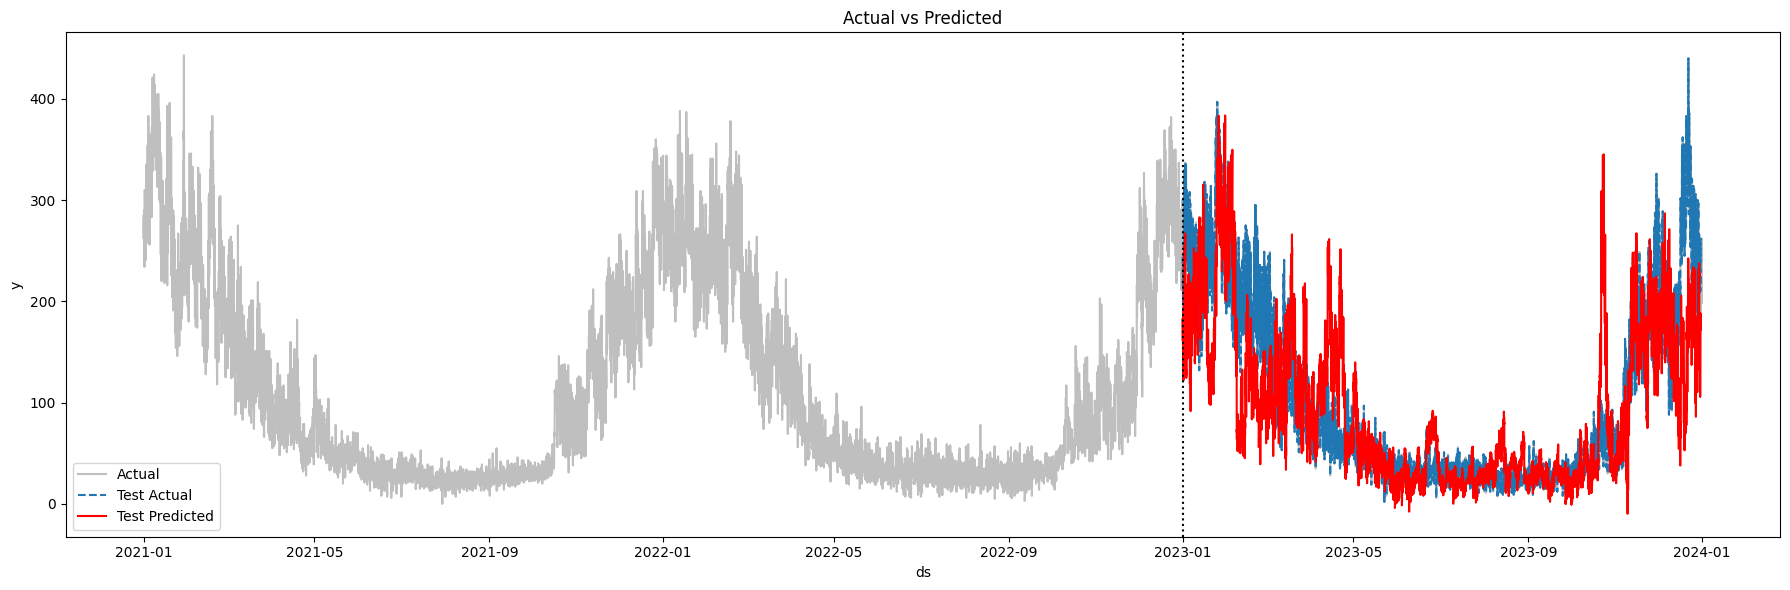

In [6]:
# ...existing code...

# preds 길이에 맞게 test_df도 잘라서 metric 계산
test_df_cut = test_df.iloc[:len(preds)].copy()

rmse, mae, mape, smape = calc_metrics(test_df_cut["y"].values, preds)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")
print(f"Inference time: {elapsed:.2f}s")

# Plot results (예측선을 빨간색으로)
df_all = pd.concat([train_df, test_df], ignore_index=True)
df_plot= pd.DataFrame({"ds": test_df_cut["ds"], "true": test_df_cut["y"], "pred": preds})
plt.figure(figsize=(18,6))
plt.plot(df_all["ds"], df_all["y"], label="Actual", color="gray", alpha=0.5)
plt.plot(df_plot["ds"], df_plot["true"], label="Test Actual", linestyle="--")
plt.plot(df_plot["ds"], df_plot["pred"], label="Test Predicted", color="red")  # 빨간색으로 변경
plt.axvline(df_plot["ds"].iloc[0], color="black", linestyle=":")
plt.xlabel("ds"); plt.ylabel("y"); plt.legend(); plt.title("Actual vs Predicted")
plt.tight_layout(); plt.show()
# ...existing code...

조금더 pap 프롬프트를 간략하게 작성-> 성능 약간 하락 rmse 57 -> 58  

[E01][B000] loss=128.5085 | MAE=137.6636 | SMAPE=176.08% | 예측값: [ 4.279356  12.4466715 25.414303 ] | 실제값: [163. 175. 184.]
[E01][B010] loss=36.8214 | MAE=31.1705 | SMAPE=74.15% | 예측값: [59.4252   60.018112 62.184513] | 실제값: [21. 32. 46.]
[E01][B020] loss=63.6046 | MAE=54.3727 | SMAPE=96.44% | 예측값: [90.50365 89.80792 75.81159] | 실제값: [41. 35. 28.]
[E01][B030] loss=94.5301 | MAE=210.7117 | SMAPE=135.01% | 예측값: [53.01604  66.17873  56.790997] | 실제값: [250. 249. 257.]
[E01][B040] loss=61.6247 | MAE=35.8738 | SMAPE=50.94% | 예측값: [12.940108 50.452618 61.225048] | 실제값: [93. 92. 79.]
[E01][B050] loss=51.1879 | MAE=49.8463 | SMAPE=75.70% | 예측값: [107.49051  108.22681  113.442245] | 실제값: [51. 50. 50.]
[E01][B060] loss=107.3018 | MAE=103.2924 | SMAPE=93.97% | 예측값: [88.36017  66.72592  74.846695] | 실제값: [200. 183. 156.]
[E01][B070] loss=108.9227 | MAE=31.2435 | SMAPE=61.97% | 예측값: [13.922578 58.573154 60.254276] | 실제값: [54. 53. 50.]
[E01][B080] loss=47.9879 | MAE=34.5152 | SMAPE=43.31% | 예측값: [111.29

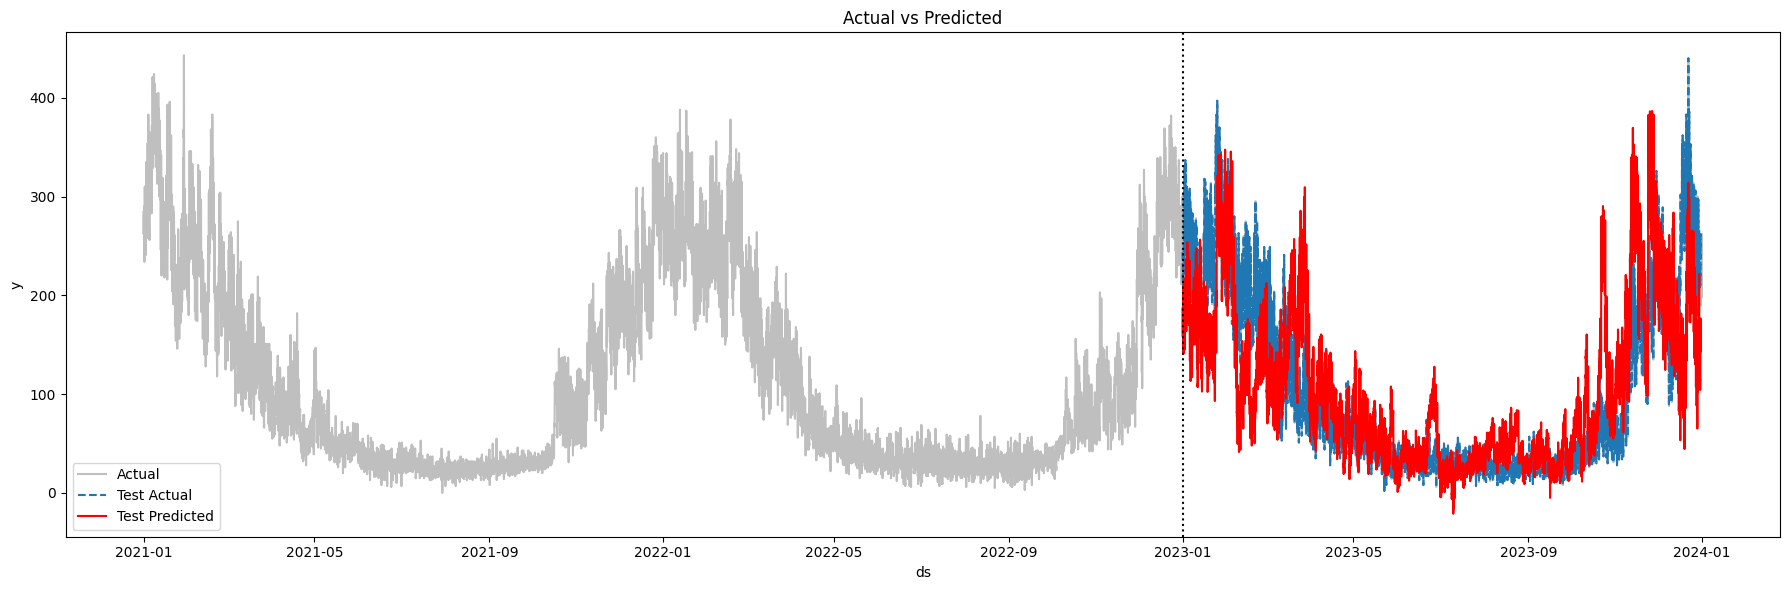

In [7]:
import gc
import torch
import math
import time
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoConfig, AutoModel, AutoTokenizer
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool
import shap

# -----------------------------
# (1) Dataset
# -----------------------------
class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, target_col="y"):
        self.seq_len   = seq_len
        self.pred_len  = pred_len
        self.target_col= target_col
        self.df        = df.reset_index(drop=True)
        self.features  = [c for c in df.columns if c not in ["ds", target_col]]
        self.data      = df[self.features].values.astype(np.float32)
        self.targets   = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        x_enc   = self.data[idx : idx + self.seq_len]
        y_label = self.targets[idx + self.seq_len : idx + self.seq_len + self.pred_len]
        return (
            torch.tensor(x_enc),                # [seq_len, n_features]
            torch.tensor([]),                   # dummy
            torch.tensor(y_label).unsqueeze(-1) # [pred_len, 1]
        )

# -----------------------------
# (2) RevIN
# -----------------------------
class RevIN(nn.Module):
    def __init__(self, num_features, affine=True, eps=1e-5):
        super().__init__()
        self.affine = affine
        self.eps    = eps
        if affine:
            self.gamma = nn.Parameter(torch.ones(1,1,num_features))
            self.beta  = nn.Parameter(torch.zeros(1,1,num_features))

    def forward(self, x, mode):
        if mode == "norm":
            m = x.mean(dim=1, keepdim=True)
            s = x.std(dim=1, keepdim=True)
            xn = (x - m) / (s + self.eps)
            if self.affine:
                xn = xn * self.gamma + self.beta
            return xn, m, s
        elif mode == "denorm":
            xn, m, s = x
            if self.affine:
                xn = (xn - self.beta) / (self.gamma + self.eps)
            return xn * (s + self.eps) + m
        else:
            raise ValueError("mode must be 'norm' or 'denorm'")

# -----------------------------
# (3) PatchEmbedding
# -----------------------------
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, dropout=0.1):
        super().__init__()
        self.patch_len = patch_len
        self.stride    = stride
        self.token_emb = nn.Linear(patch_len, d_model)
        self.dropout   = nn.Dropout(dropout)

    def forward(self, x):
        B, T, F = x.shape
        Lp, S   = self.patch_len, self.stride
        num_patches = math.floor((T - Lp) / S) + 2
        total_len   = (num_patches - 1) * S + Lp
        pad = total_len - T
        if pad > 0:
            x = nn.functional.pad(x, (0,0,0,pad), mode="replicate")
        x = x.permute(0,2,1)                                    # [B, F, T]
        xu = x.unfold(2, Lp, S).contiguous().view(B*F, num_patches, Lp)
        pe = self.token_emb(xu).view(B, F * num_patches, -1)   # [B, F*num_patches, d_model]
        return self.dropout(pe), F, num_patches

# -----------------------------
# (4) ReprogrammingLayer
# -----------------------------
class ReprogrammingLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, dropout=0.1):
        super().__init__()
        d_keys = d_keys or (d_model // n_heads)
        self.n_heads = n_heads
        self.query_proj = nn.Linear(d_model, d_keys * n_heads)
        self.key_proj   = nn.Linear(d_llm,   d_keys * n_heads)
        self.value_proj = nn.Linear(d_llm,   d_keys * n_heads)
        self.out_proj   = nn.Linear(d_keys * n_heads, d_llm)
        self.dropout    = nn.Dropout(dropout)

    def forward(self, tgt, src, val):
        B, L, _ = tgt.shape
        S, _    = src.shape
        H       = self.n_heads
        E       = int(tgt.size(-1) // H)

        Q = self.query_proj(tgt).view(B, L, H, E)    # [B, L, H, E]
        K = self.key_proj(src).view(S, H, E)         # [S, H, E]
        V = self.value_proj(val).view(S, H, E)       # [S, H, E]

        scores = torch.einsum("blhe,she->bhls", Q, K) / math.sqrt(E)
        attn   = torch.softmax(scores, dim=-1)
        attn   = self.dropout(attn)
        out    = torch.einsum("bhls,she->blhe", attn, V).reshape(B, L, H*E)
        return self.out_proj(out)

# -----------------------------
# (5) FlattenHead
# -----------------------------
class FlattenHead(nn.Module):
    def __init__(self, n_vars, num_patches, d_llm, pred_len, dropout=0.1):
        super().__init__()
        in_feats  = n_vars * num_patches * d_llm
        out_feats = pred_len * 1
        self.flatten = nn.Flatten(start_dim=1)
        self.linear  = nn.Linear(in_feats, out_feats)
        self.dropout = nn.Dropout(dropout)
        self.pred_len= pred_len

    def forward(self, x):
        B = x.size(0)
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x.view(B, self.pred_len, 1)

# -----------------------------
# (6) TimeLLMMulti
# -----------------------------
class TimeLLMMulti(nn.Module):
    def __init__(
        self, seq_len, pred_len, enc_in,
        d_model=768, d_ff=768, patch_len=48, stride=24,
        llm_layers=6, n_heads=12, dropout=0.1, prompt_maxlen=1024,
        num_prototypes=256
    ):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len= pred_len
        self.enc_in  = enc_in
        self.prompt_maxlen = prompt_maxlen

        # 1) Frozen LLM backbone
        cfg = AutoConfig.from_pretrained(
            "distilgpt2",
            n_embd   = d_ff,
            n_layer  = llm_layers,
            n_head   = n_heads,
            output_hidden_states=False,
            output_attentions=False,
            add_cross_attention=False
        )
        self.llm = AutoModel.from_pretrained("distilgpt2", config=cfg)
        for p in self.llm.parameters():
            p.requires_grad = False
        self.tokenizer = AutoTokenizer.from_pretrained("distilgpt2", use_fast=True)
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # 2) RevIN
        self.revin_in  = RevIN(enc_in)
        self.revin_out = RevIN(enc_in)

        # 3) PatchEmbedding + projection
        self.patch_embed = PatchEmbedding(d_model, patch_len, stride, dropout)
        self.proj_pe     = nn.Linear(d_model, d_ff) if d_model != d_ff else nn.Identity()

        # 4) Text prototypes
        W = self.llm.get_input_embeddings().weight  # [vocab_size, d_ff]
        vocab_size = W.size(0)
        self.mapping_layer = nn.Linear(vocab_size, num_prototypes, bias=False)
        self.prototype_emb = nn.Parameter(self.mapping_layer.weight @ W.detach())

        # 5) Reprogramming
        self.reprog = ReprogrammingLayer(d_model=d_ff, n_heads=n_heads, d_llm=d_ff, dropout=dropout)

        # 6) Prediction head
        max_patches = math.floor((seq_len - patch_len) / stride) + 2
        self.head = FlattenHead(n_vars=enc_in, num_patches=max_patches, d_llm=d_ff, pred_len=pred_len, dropout=dropout)

    def forward(self, x_enc, prompt: str = None):
        B = x_enc.size(0)

        # a) RevIN normalization
        x_norm, mean, std = self.revin_in(x_enc, "norm")

        # b) Patch embedding + projection
        pe, F, num_p = self.patch_embed(x_norm)       # [B, F*num_p, d_model]
        pe = self.proj_pe(pe)                         # [B, F*num_p, d_ff]

        # c) Reprogramming with prototypes
        rep = self.reprog(pe, self.prototype_emb, self.prototype_emb)  # [B, F*num_p, d_ff]

        # d) Prompt embedding
        prompts = [prompt or ""] * B
        ids = self.tokenizer(prompts, padding=True, truncation=True,
                             max_length=self.prompt_maxlen,
                             return_tensors="pt").input_ids.to(x_enc.device)
        p_emb = self.llm.get_input_embeddings()(ids)  # [B, Lp, d_ff]

        # e) Concat and LLM forward
        inp = torch.cat([p_emb, rep], dim=1)          # [B, Lp + F*num_p, d_ff]
        llm_out = self.llm(inputs_embeds=inp).last_hidden_state
        rep_out = llm_out[:, -rep.size(1):, :]        # [B, F*num_p, d_ff]

        # f) Prediction head
        pred = self.head(rep_out)                     # [B, pred_len, 1]

        # g) Denormalize & slice single channel (y only)
        out_all = self.revin_out((pred, mean, std), "denorm")  # [B, pred_len, enc_in]
        out     = out_all[..., 0].unsqueeze(-1)                # [B, pred_len, 1]
        return out

# -----------------------------
# Metrics
# -----------------------------
def calc_metrics(true, pred):
    rmse  = np.sqrt(np.mean((true - pred) ** 2))
    mae   = np.mean(np.abs(true - pred))
    mape  = np.mean(np.abs((true - pred) / (true + 1e-8))) * 100
    smape = 100 * np.mean(2 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + 1e-8))
    return rmse, mae, mape, smape

# -----------------------------
# Training & Inference
# -----------------------------
if __name__ == "__main__":
    # Load & preprocess
    df = pd.read_csv("A지사_train.csv")
    df["ds"] = pd.to_datetime(df["ds"])
    df = df.rename(columns={
        "TA":"Temperature","WD":"WindDirection","WS":"WindSpeed",
        "RN_DAY":"DailyPrecipitation","RN_HR1":"HourlyPrecipitation",
        "HM":"Humidity","SI":"SolarIrradiance","ta_chi":"ApparentTemperature"
    })
    train_df = df[df["ds"].dt.year.isin([2021,2022])].reset_index(drop=True)
    test_df  = df[df["ds"].dt.year==2023].reset_index(drop=True)

    seq_len, pred_len = 24*7, 24*1
    batch_size, val_ratio = 4, 0.2

    ds      = TimeSeriesDataset(train_df, seq_len, pred_len, "y")
    n_val   = int(len(ds) * val_ratio)
    n_train = len(ds) - n_val
    train_ds, val_ds = random_split(ds, [n_train, n_val])
    tr_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    va_loader = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    feature_names = train_ds.dataset.features if hasattr(train_ds, "dataset") else train_ds.features

    # CatBoost 해석력
    best_params = {
        'iterations': 1248, 'depth': 4, 'learning_rate': 0.0205, 'l2_leaf_reg': 8.26,
        'bagging_temperature': 0.815, 'random_strength': 0.59, 'border_count': 168,
        'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 11, 'subsample': 0.87
    }
    cat_features = []
    train_pool = Pool(train_df[feature_names], train_df["y"], cat_features=cat_features)
    cat_model = CatBoostRegressor(**best_params, verbose=0)
    cat_model.fit(train_pool)

    # Feature Importance 순서만
    cb_importances = cat_model.get_feature_importance(type='FeatureImportance')
    cb_sorted_idx = np.argsort(-cb_importances)
    cb_sorted_features = [feature_names[i] for i in cb_sorted_idx]
    cb_imp_str = ", ".join(cb_sorted_features)

    # SHAP 상위 피처 순서만
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(train_df[feature_names].iloc[:200])
    shap_abs_mean = np.abs(shap_values).mean(axis=0)
    shap_sorted_idx = np.argsort(-shap_abs_mean)
    shap_sorted_features = [feature_names[i] for i in shap_sorted_idx]
    shap_top_str = ", ".join(shap_sorted_features[:3])

    # 상관계수: 문장으로
    corr = train_df[feature_names].corrwith(train_df["y"])
    corr_sorted = corr.abs().sort_values(ascending=False)
    corr_sentence = "Features most correlated with y are: " + ", ".join(corr_sorted.index[:3]) + "."

    # 통계
    stats = train_df[feature_names].describe().T
    stats_str = "\n".join([f"{c}: mean={r['mean']:.2f}, std={r['std']:.2f}, min={r['min']:.2f}, max={r['max']:.2f}" for c,r in stats.iterrows()])

    # 프롬프트 작성
    domain_str = "Domain: Energy demand forecasting for a branch office."
    instruct_str = "Instruction: Predict future values of y using the given features."
    pap_prompt = f"""{domain_str}

{instruct_str}

[feature_importance]
Most important features by CatBoost: {cb_imp_str}

[shap_top_features]
Top features by SHAP: {shap_top_str}

[correlation_with_target]
{corr_sentence}

[statistics]
{stats_str}
"""

    # Model, optimizer, scheduler, criterion
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TimeLLMMulti(seq_len, pred_len, len(feature_names)).to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.5)
    criterion = nn.L1Loss()
    scaler    = GradScaler()

    best_val, patience, counter = float("inf"), 3, 0
    epochs = 50

    # Training loop
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for i, (x, _, y) in enumerate(tr_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            with autocast():
                o = model(x, prompt=pap_prompt)
                if o.shape != y.shape:
                    o = o[..., 0:1]
                loss = criterion(o, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            if i % 10 == 0:
                pred_np = o[0, :, 0].detach().cpu().numpy()
                true_np = y[0, :, 0].detach().cpu().numpy()
                _, mae, _, smape = calc_metrics(true_np, pred_np)
                print(f"[E{epoch:02d}][B{i:03d}] loss={loss.item():.4f} | MAE={mae:.4f} | SMAPE={smape:.2f}% | 예측값: {pred_np[:3]} | 실제값: {true_np[:3]}")
        # Validation
        model.eval()
        val_loss, val_mae, val_sm = 0.0, 0.0, 0.0
        with torch.no_grad():
            for x, _, y in va_loader:
                x, y = x.to(device), y.to(device)
                o = model(x, prompt=pap_prompt)
                if o.shape != y.shape:
                    o = o[..., 0:1]
                val_loss += criterion(o, y).item()
                _, mae, _, sm = calc_metrics(y.cpu().numpy().flatten(), o.cpu().numpy().flatten())
                val_mae += mae
                val_sm  += sm
        val_loss /= len(va_loader)
        val_mae  /= len(va_loader)
        val_sm   /= len(va_loader)
        print(f"Epoch {epoch:02d}| train {train_loss:.4f}| val {val_loss:.4f}| MAE {val_mae:.4f}| SMAPE {val_sm:.2f}%")

        scheduler.step(val_loss)
        if val_loss < best_val:
            best_val, counter = val_loss, 0
            torch.save(model.state_dict(), "best_timellm_fullprompt.pt")
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping.")
                break

    # Testing
    model.load_state_dict(torch.load("best_timellm_fullprompt.pt"))
    model.eval()
    test_in  = pd.concat([train_df.tail(seq_len), test_df], ignore_index=True)
    test_ds  = TimeSeriesDataset(test_in, seq_len, pred_len, "y")
    preds    = []
    start_t  = time.time()
    with torch.no_grad():
        for idx in range(0, len(test_ds), pred_len):
            x, _, _ = test_ds[idx]
            x = x.unsqueeze(0).to(device)
            y_hat = model(x, prompt=pap_prompt)[0,:,0].cpu().numpy()
            preds.extend(y_hat.tolist())
    preds = np.array(preds)[:len(test_df)]  # test_df 길이에 맞게 자르기
    elapsed = time.time() - start_t

    # preds 길이에 맞게 test_df도 잘라서 metric 계산
    test_df_cut = test_df.iloc[:len(preds)].copy()

    rmse, mae, mape, smape = calc_metrics(test_df_cut["y"].values, preds)
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE : {mae:.4f}")
    print(f"Test MAPE: {mape:.2f}%")
    print(f"Test SMAPE: {smape:.2f}%")
    print(f"Inference time: {elapsed:.2f}s")

    # Plot results (예측선을 빨간색으로)
    df_all = pd.concat([train_df, test_df], ignore_index=True)
    df_plot= pd.DataFrame({"ds": test_df_cut["ds"], "true": test_df_cut["y"], "pred": preds})
    plt.figure(figsize=(18,6))
    plt.plot(df_all["ds"], df_all["y"], label="Actual", color="gray", alpha=0.5)
    plt.plot(df_plot["ds"], df_plot["true"], label="Test Actual", linestyle="--")
    plt.plot(df_plot["ds"], df_plot["pred"], label="Test Predicted", color="red")
    plt.axvline(df_plot["ds"].iloc[0], color="black", linestyle=":")
    plt.xlabel("ds"); plt.ylabel("y"); plt.legend(); plt.title("Actual vs Predicted")
    plt.tight_layout(); plt.show()